In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import psutil
from functools import reduce
from tqdm import tqdm_notebook
from multiprocessing import Process
from scipy.stats import moment
from IPython.display import display
import gen_features
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read in multiple train chunks 

In [2]:
### Read training sets and confirm indices
seg_nums = range(56,70)
segment_list = []
for k in seg_nums:
    data = pd.read_csv(os.path.join("Data","train_chunk{0}.csv".format(k))).iloc[:,1:]
    for i in [5,18,24]:
        start = i*150000
        stop = (i+1)*150000
        segment_list.append(data.loc[start:stop])

In [75]:
def add_time_to_failure(axis,segment,segment_list):
    axis2 = axis.twinx()
    axis2.axhline(segment['time_to_failure'].iloc[-1],color='r')
    axis2.set_ylim((min(s['time_to_failure'].min() for s in segment_list),
                max(s['time_to_failure'].max() for s in segment_list)+1))

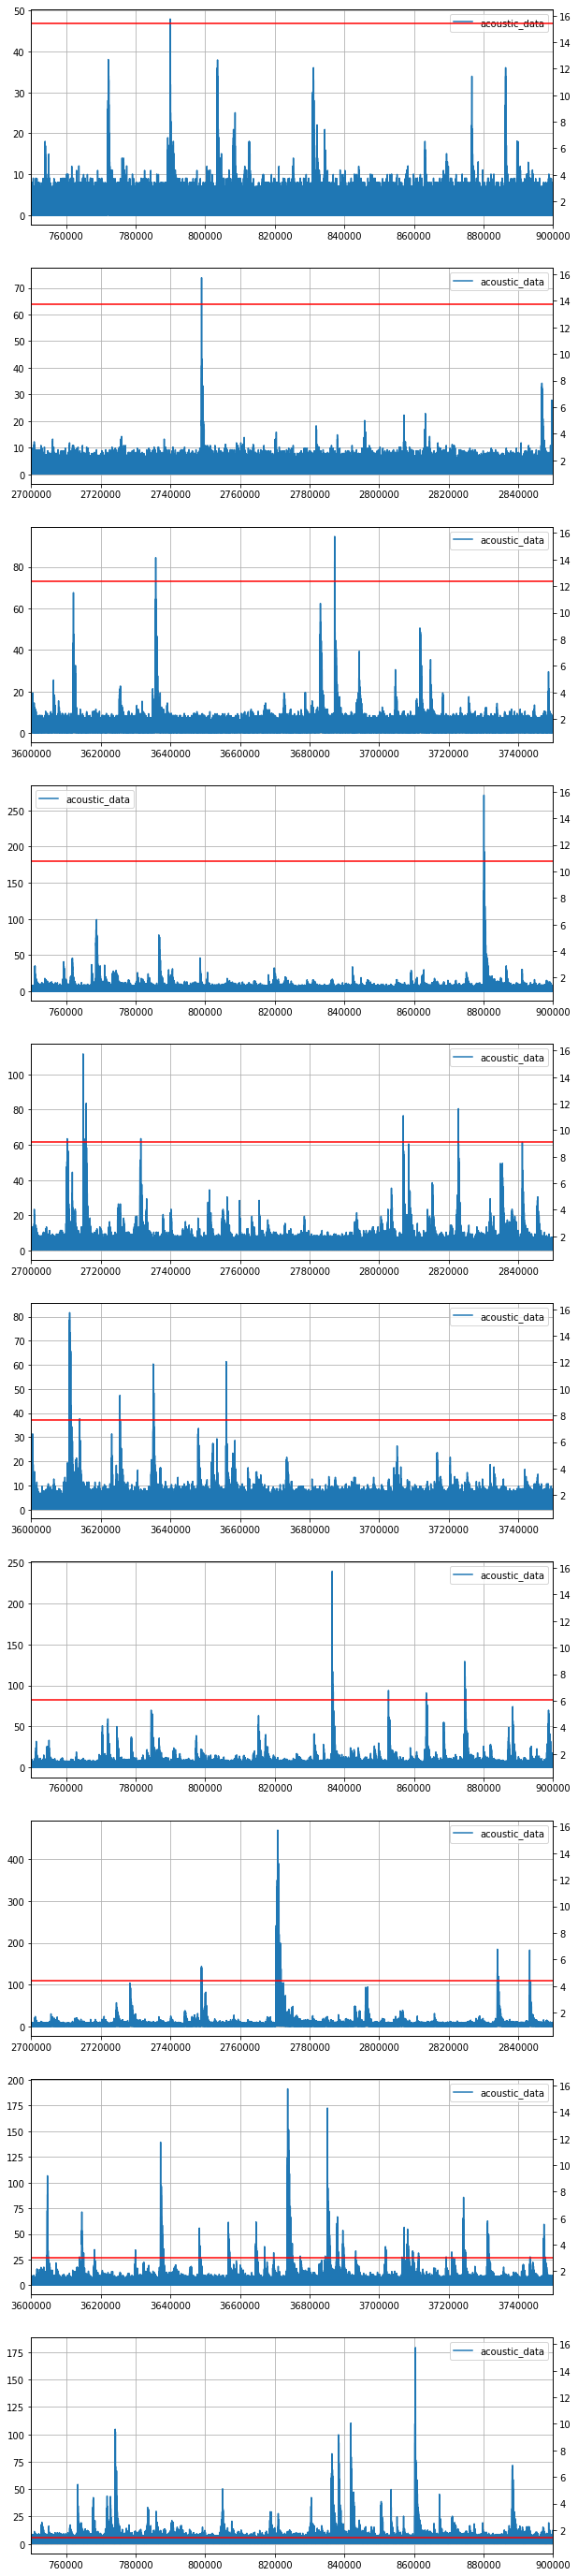

In [183]:
nrows = min(10,len(segment_list)+1)
filt_segment_list = list(segment_list[::int(len(segment_list)/nrows)])
fig, axes = plt.subplots(nrows,1,figsize=(10,5*nrows))
for segment,axis in zip(filt_segment_list,axes):
    cent_segment = segment['acoustic_data']-segment['acoustic_data'].mean()
    axis.plot(segment.index,cent_segment.abs())
    add_time_to_failure(axis,segment,segment_list)
    axis.legend()
    axis.grid()
    axis.set_xlim((segment.index[0],segment.index[-1]))

### Generate and plot stats features

In [191]:
def num_peaks(segment):
    cent_segment = segment['acoustic_data']-segment['acoustic_data'].mean()
    return np.sum(cent_segment>cent_segment.quantile(0.995))

In [192]:
from sklearn.preprocessing import MinMaxScaler
feat_names = ['skew','kurtosis','5','6','7','outliers','time_to_failure']
feat = []
feat.append([seg['acoustic_data'].skew() for seg in segment_list])
feat.append([seg['acoustic_data'].kurtosis() for seg in segment_list])
for k in range(5,8):
    feat.append([moment(seg['acoustic_data'],k)/seg['acoustic_data'].std()**(k-2) for seg in segment_list])
feat.append([num_peaks(seg) for seg in segment_list])
feat.append([seg['time_to_failure'].iloc[-1] for seg in segment_list])

feat_norm = []
for f in feat[:-1]:
    norm = MinMaxScaler().fit_transform(np.array(f).reshape(-1,1))
    feat_norm.append(norm.ravel())
feat_norm.append(feat[-1])
feat_df = pd.DataFrame(np.stack(feat_norm).T,columns=feat_names)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [193]:
feat_df.head()

,skew,kurtosis,5,6,7,outliers,time_to_failure
0,0.259129,0.009940,0.020583,0.000001,0.015422,0.119760,15.440298
1,0.264188,0.000000,0.020591,0.000000,0.015423,0.173653,14.933897
2,0.202923,0.100146,0.020408,0.000193,0.015358,0.604790,14.699798
3,0.264404,0.011337,0.020604,0.000006,0.015426,0.497006,14.270999
4,0.322886,0.040670,0.020708,0.000065,0.015471,0.335329,13.764499


(0, 1)

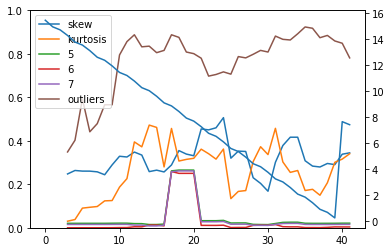

In [195]:
axis = feat_df.iloc[:,:-1].rolling(4).mean().plot()
axis2 = axis.twinx()
axis2.plot(feat_df.iloc[:,-1])
axis.set_ylim((0,1))

### Rolling means/stds

In [103]:
segment['acoustic_data'].rolling(10).mean().std()

3.9059510961475032

In [104]:
segment['acoustic_data'].std()

6.830769943735183

In [115]:
from sklearn.preprocessing import MinMaxScaler
feat_names = ['r1_std','r10_std','r100_std','r1000_std','time_to_failure']
feat = []
feat.append([seg['acoustic_data'].std() for seg in segment_list])
for k in [10,100,1000]:
    feat.append([seg['acoustic_data'].rolling(k).mean().std() for seg in segment_list])
feat.append([seg['time_to_failure'].iloc[-1] for seg in segment_list])

feat_norm = []
for f in feat[:-1]:
    norm = MinMaxScaler().fit_transform(np.array(f).reshape(-1,1))
    feat_norm.append(norm.ravel())
feat_norm.append(feat[-1])
feat_df = pd.DataFrame(np.stack(feat_norm).T,columns=feat_names)

In [116]:
feat_df.head()

,r1_std,r10_std,r100_std,r1000_std,time_to_failure
0,0.003678,0.002469,0.007851,0.106413,15.440298
1,0.000000,0.000000,0.000000,0.021275,14.933897
2,0.017511,0.014609,0.008266,0.052678,14.699798
3,0.005087,0.003704,0.005223,0.073559,14.270999
4,0.000986,0.000498,0.010031,0.128739,13.764499


(0, 0.2)

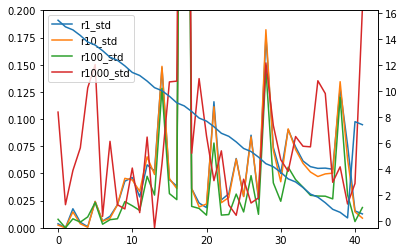

In [117]:
axis = feat_df.iloc[:,:-1].plot()
axis2 = axis.twinx()
axis2.plot(feat_df.iloc[:,-1])
axis.set_ylim((0,0.2))

### Derivatives/Integral Features

In [157]:
from sklearn.preprocessing import MinMaxScaler
feat_names = ['std','diff_mean','diff_std','2diff_mean','cumsum_max','time_to_failure']
feat = []
feat.append([seg['acoustic_data'].std() for seg in segment_list])
feat.append([seg['acoustic_data'].diff().mean() for seg in segment_list])
feat.append([seg['acoustic_data'].diff().std() for seg in segment_list])
feat.append([seg['acoustic_data'].diff().diff().mean() for seg in segment_list])
feat.append([(seg['acoustic_data']-seg['acoustic_data'].mean()).cumsum().abs().max() for seg in segment_list])
feat.append([seg['time_to_failure'].iloc[-1] for seg in segment_list])

feat_norm = []
for f in feat[:-1]:
    norm = MinMaxScaler().fit_transform(np.array(f).reshape(-1,1))
    feat_norm.append(norm.ravel())
feat_norm.append(feat[-1])
feat_df = pd.DataFrame(np.stack(feat_norm).T,columns=feat_names)

In [158]:
feat_df.head()

,std,diff_mean,diff_std,2diff_mean,cumsum_max,time_to_failure
0,0.003678,0.622222,0.002881,0.300000,0.751615,15.440298
1,0.000000,0.600000,0.000000,0.633333,0.472882,14.933897
2,0.017511,0.577778,0.011589,0.366667,0.523656,14.699798
3,0.005087,0.800000,0.003566,0.466667,0.226877,14.270999
4,0.000986,0.600000,0.000623,0.400000,0.441750,13.764499


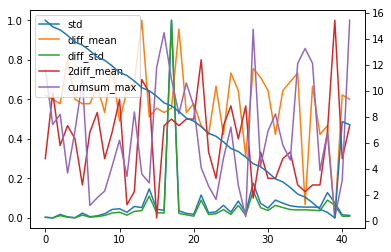

In [159]:
axis = feat_df.iloc[:,:-1].plot()
axis2 = axis.twinx()
axis2.plot(feat_df.iloc[:,-1])
# axis.set_ylim((0,0.2))